# CPU time analysis

## Setup

In [1]:
from __future__ import division

import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from scipy import stats
from elasticsearch import Elasticsearch, helpers

np.set_printoptions(threshold=np.inf)

%matplotlib inline

pp = pprint.PrettyPrinter()

range_func = range  # hist's range arg will override python's range() func

## Open connection to ES

In [2]:
#es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
es = Elasticsearch([{'host':'cl-analytics.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

## Function to list all jobs\_archive\_* indices in the last N days

In [4]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        try:
            day = datetime.datetime.strptime(day, datefmt).date()
            diff = today - day
            if until <= diff.days < days + until:
                filtered.append(i.rstrip())
        except:
            continue
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [5]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 10, 0)
ind = ','.join(ind)

I select only jobs with at least one event, successful, with a core count of at least one and that ran for at least 60 seconds.

I exclude test and analysis jobs.

I aggregate jobs by _processingtype_, _transformation_, _atlasrelease_, _computingsite_ and _jeditaskdid_.
In practice, all jobs in a task have the same value of all these variables save for the site, so each bucket corresponds to a combination of (_jeditaskid_, _computingsite_).

I record these quantities:

* Average of CPU time per event
* Average of wall-clock time per event
* Total CPU time
* Total wall-clock time (that is, multiplied by the number of cores)
* Average of core count
* Total number of events
* Average of CPU time divided by wall-clock time

Already at this level there's a theoretical flaw: averages of time and efficiency are done from the values of each individual job, disregarding the number of events in the job. The averages are correct only if all jobs in a task process the same number of jobs. **This is not strictly the case, but usually all jobs in a task have at least very similar numbers of events**.

In [6]:
# https://www.elastic.co/guide/en/elasticsearch/guide/master/combining-filters.html
s = {
    "size": 0,
    "query": {
        "constant_score": {
            "filter": {
                "bool": {
                    "must": [
                        {"range": {"nevents": {"gte": 1}}},
                        {"range": {"corecount": {"gte": 1}}},
                        {"range": {"wall_time": {"gt": 60, "lt": 2590000}}},
                        {"match": {"prodsourcelabel":"managed"}},
                        {"match": {"jobstatus": "finished"}},
                        {"script": {
                            "script": {
                                "inline": "doc['cpuconsumptiontime'].value/doc['wall_time'].value/doc['corecount'].value < 2.",
                                "lang": "expression"
                            }
                          }
                        }

                    ],
                    "must_not": [
                        {"wildcard": {"processingtype": "panda*"}},
                        {"wildcard": {"processingtype": "pmerge*"}},
                        {"wildcard": {"processingtype": "merge*"}},
                        {"wildcard": {"processingtype": "ganga*"}},
                        {"wildcard": {"processingtype": "hammercloud*"}},
                        {"wildcard": {"computingsite": "BOINC*"}}
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "atlrel": {
                            "terms": {
                                "field": "atlasrelease",
                                "size": 1000
                            },
                            "aggs": {
                                "site": {
                                    "terms": {
                                        "field": "computingsite",
                                        "size": 1000
                                    },
                                    "aggs": {
                                        "cputype": {
                                            "terms": {
                                                "field": "cpuconsumptionunit",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "jtask": {
                                                    "terms": {
                                                        "field": "jeditaskid",
                                                        "size": 100000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "script": {
                                                                    "inline": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                                                    "lang": "expression"
                                                                }
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "script": {
                                                                    "inline": "(doc['nevents'].value) ? doc['wall_time'].value * doc['corecount'].value / doc['nevents'].value : 0",
                                                                    "lang": "expression"
                                                                }
                                                            }
                                                        },
                                                        "3": {
                                                            "sum": {
                                                                "field": "cpuconsumptiontime"
                                                            }
                                                        },
                                                        "4": {
                                                            "sum": {
                                                                "script": {
                                                                    "inline": "doc['wall_time'].value * doc['corecount'].value",
                                                                    "lang": "expression"
                                                                }
                                                            }
                                                        },
                                                        "5": {
                                                            "avg": {
                                                                "field": "actualcorecount"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "corecount"
                                                            }
                                                        },
                                                        "7": {
                                                            "sum": {
                                                                "field": "nevents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "script": {
                                                                    "inline": "doc['cpuconsumptiontime'].value/doc['wall_time'].value/doc['corecount'].value",
                                                                    "lang": "expression"
                                                                }
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

In [7]:
for ptype in res['aggregations']['ptypes']['buckets']:
    print(ptype['key'])

evgen
pile
simul
recon
reprocessing
overlay
validation


## Write data to a CSV file

In [8]:
output_file = 'task_cpu_90d_xxx.csv'

In [9]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['atlrel']['buckets']
            for b3 in buckets3:
                atlrel = b3['key']
                buckets4 = b3['site']['buckets']
                for b4 in buckets4:
                    site = b4['key']
                    buckets5 = b4['cputype']['buckets']
                    for b5 in buckets5:
                        cputype = b5['key']
                        buckets6 = b5['jtask']['buckets']
                        for b6 in buckets6:
                            jtask = b6['key']
                            writer.writerow([
                                jtask,
                                ptype,
                                transf,
                                atlrel,
                                site,
                                cputype,
                                b6['1']['count'],
                                b6['1']['avg'],
                                b6['1']['std_deviation'],
                                b6['2']['avg'],
                                b6['2']['std_deviation'],
                                b6['3']['value'],
                                b6['4']['value'],
                                b6['5']['value'],
                                b6['6']['value'],
                                b6['7']['value'],
                                b6['8']['value']
                                ])

## Import to a DataFrame

In [10]:
#input_file = 'task_cpu_2016.csv'
input_file = output_file

In [11]:
df = pd.read_csv(input_file, 
                 dtype={'cpu_n': 'float'}, 
                 names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                        'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                        'wallevt_rms', 'cpu', 'wc', 'actualcores', 'cores', 'jevts', 'eff'])

The following redefinitions improve the wall-clock and efficiency values by using actualcorecount instead of corecount when available.

In [12]:
df['wallevt_avg'] = (df.wallevt_avg * df.actualcores / df.cores).fillna(df.wallevt_avg)
df['wallevt_rms'] = (df.wallevt_rms * df.actualcores / df.cores).fillna(df.wallevt_rms)
df['wc'] = (df.wc * df.actualcores / df.cores).fillna(df.wc)
df['eff'] = (df.eff * df.cores / df.actualcores).fillna(df.eff)

Grouping by _processingtype_ and _transformation_ to calculate e.g. the average CPU time per event for each combination has a problem: one cannot simply average the values in the same group because this does not take into account the fact that different values have different statistical weights. So, one must use as weights the number of events in each bucket.
Unfortunately pandas does not have a simple way to do it for more than one quantity.

## Averages of wall-clock times per event

In [13]:
# Define aggregation
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

# Define function to average a given quantity using the number of events es weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the correctly averaged CPU time per event
a = grouped.apply(weighted_avg,'wallevt_avg', 'wc')
a

processingtype  transformation    
evgen           Generate_tf.py         782.036278
                Generate_trf.py        572.685242
overlay         OverlayChain_tf.py    1096.334093
                Reco_tf.py              76.464374
pile            OverlayChain_tf.py    1067.985717
                Reco_tf.py              96.758001
recon           Reco_tf.py              47.703688
                Trig_reco_tf.py         21.116621
reprocessing    AODMerge_tf.py           5.013309
                ESDMerge_tf.py           3.113676
                HISTMerge_tf.py          0.034816
                Reco_tf.py              80.159191
simul           AtlasG4_tf.py           61.847694
                Sim_tf.py              570.004335
validation      Sim_tf.py              522.186099
dtype: float64

## Some statistics

The following is the list of (processingtype, transformation) combinations with some statistics.
Rows are sorted by decreasing wall-clock time.

In [14]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({'jeditaskid': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'jevts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,transformation,wc,cpuevt_avg,jevts,cores,wallevt_avg,njobs,jeditaskid
0,evgen,Generate_tf.py,4.473757e+10,175.576282,565421300.0,1.000000,180.680012,817921,1847
5,pile,Reco_tf.py,3.501819e+10,62.389984,482027804.0,7.970292,93.839613,266409,1944
13,simul,Sim_tf.py,3.310105e+10,292.396400,126160540.0,4.892153,312.098309,255652,1390
6,recon,Reco_tf.py,1.109774e+09,27.020419,82355789.0,7.243243,56.490511,42726,26
2,overlay,OverlayChain_tf.py,9.944517e+08,1021.966380,1030000.0,1.000000,1046.154955,10300,10
11,reprocessing,Reco_tf.py,7.080685e+08,89.528856,19372342.0,4.043478,705.589115,12488,218
4,pile,OverlayChain_tf.py,4.212472e+08,937.579547,458600.0,1.000000,959.685827,4586,9
14,validation,Sim_tf.py,2.061743e+08,328.051412,918250.0,8.000000,3517.054327,2635,10
1,evgen,Generate_trf.py,1.101161e+08,607.043645,200000.0,1.000000,619.682054,2000,2
7,recon,Trig_reco_tf.py,8.251741e+07,13.425624,7873680.0,1.000000,28.947179,46019,9


## Jobs per task

29.2396907216


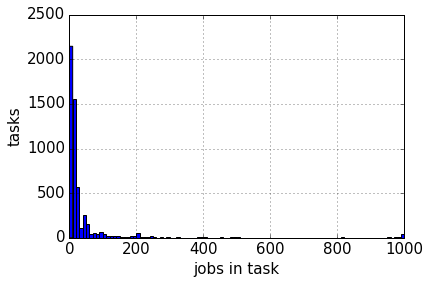

In [15]:
range_func = range  # hist's range arg overrides python's range() func

plt.rcParams.update({'font.size': 15})
grouped = df.groupby(['processingtype', 'jeditaskid'], as_index=False)
a = grouped['njobs'].sum()
print(stats.trim_mean(a['njobs'], 0.05))
fig = a.njobs.hist(bins=100, log=False, range=[0., 1000.])
plt.xlabel('jobs in task')
plt.ylabel('tasks')

## Events per task

47519.5407981


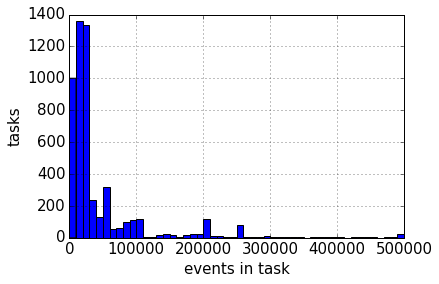

In [16]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['jevts'].sum()
print(stats.trim_mean(a['jevts'], 0.05))
fig = a['jevts'].hist(bins=50, range=[0., 5e5], log=False)
plt.xlabel('events in task')
plt.ylabel('tasks')

## Distribution of efficiency

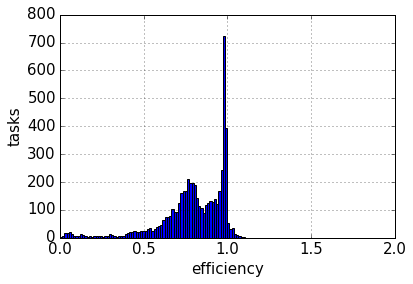

In [17]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=150, log=False, range=(0., 2.))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency')
plt.ylabel('tasks')

In the plot above, note the existence of efficiencies larger than 1! This has to be understood.
UPDATE: this came from jobs with an abnormally low WC time (a multiple of 60 s). After requiring that the efficiency of a job is less than 1.1, the average efficiency very rarely exceeds 1.0 (but it still happens). In fact, there are also some jobs left where the CPU time is ~10-20% higher than the wall-clock time, which is also not explained at the moment.

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that account for less than 1.5% of the total wall-clock time, are ignored.

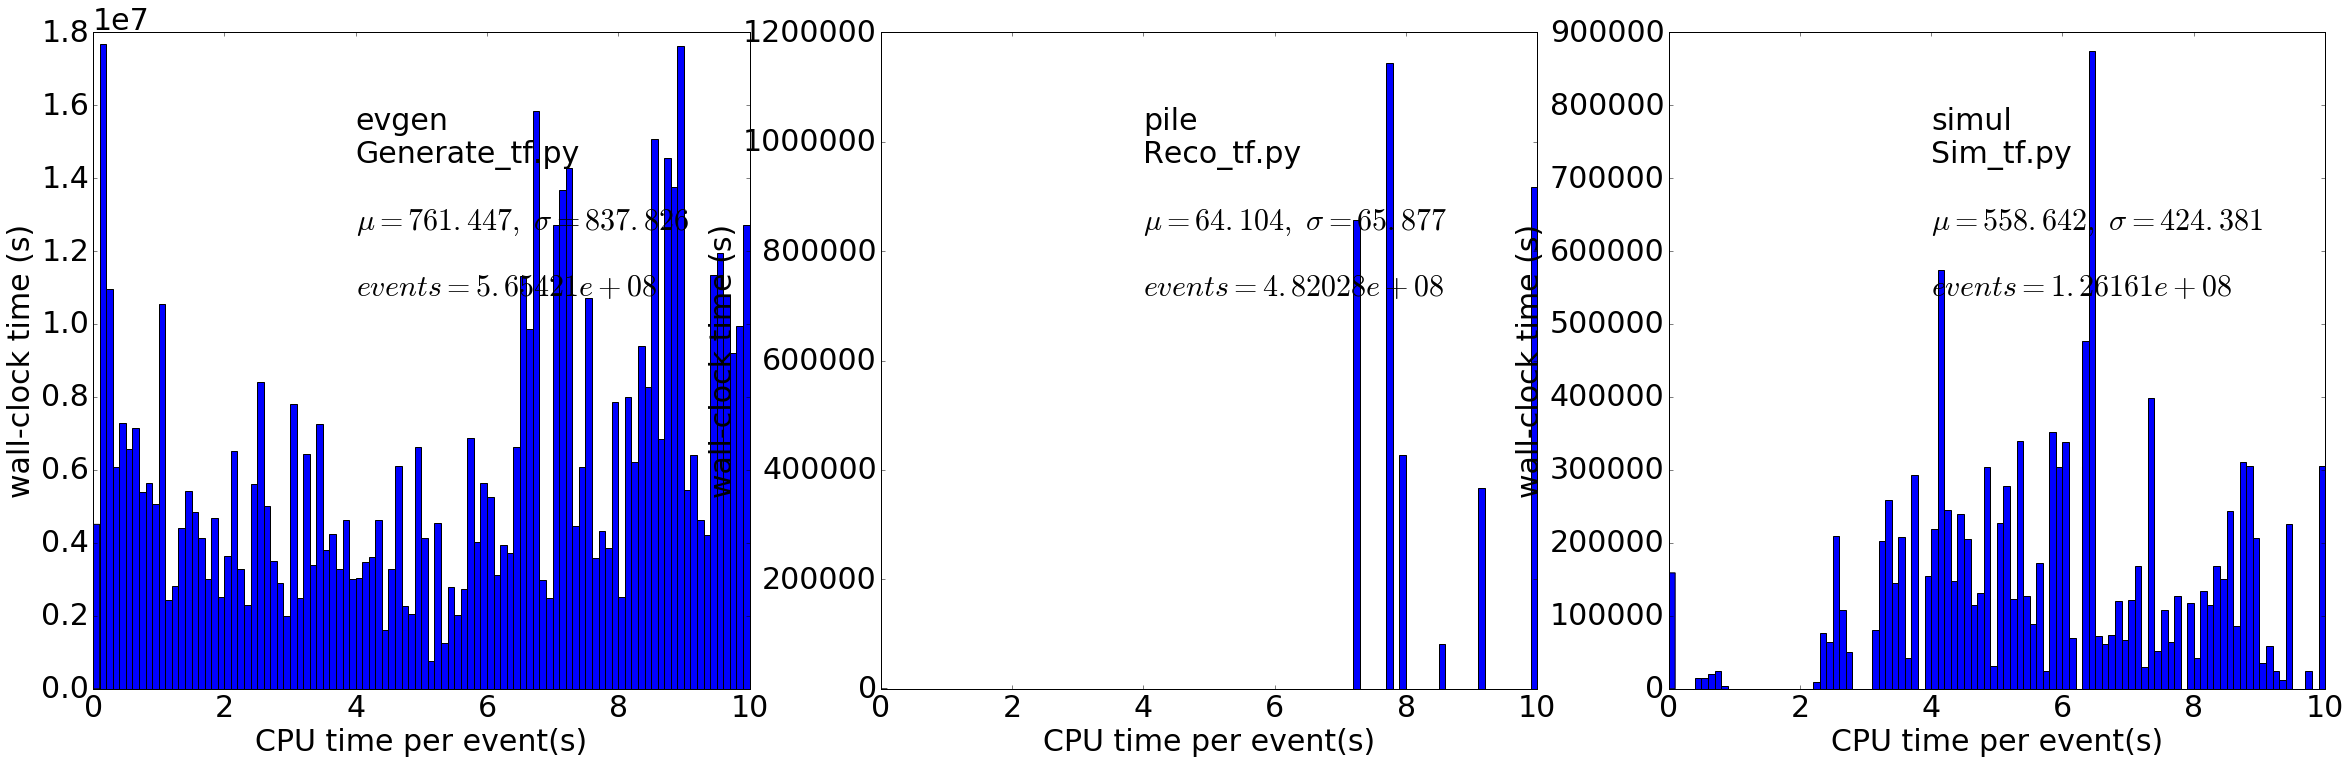

In [18]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
#    range = [0., min(mean + std * 4., 10000.)]
    range = [0., 10.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stat2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stat)
        plt.text(t_x(.4), t_y(.6), stat2)
    i += 1

Let's redo the plots aggregating only by processingtype.

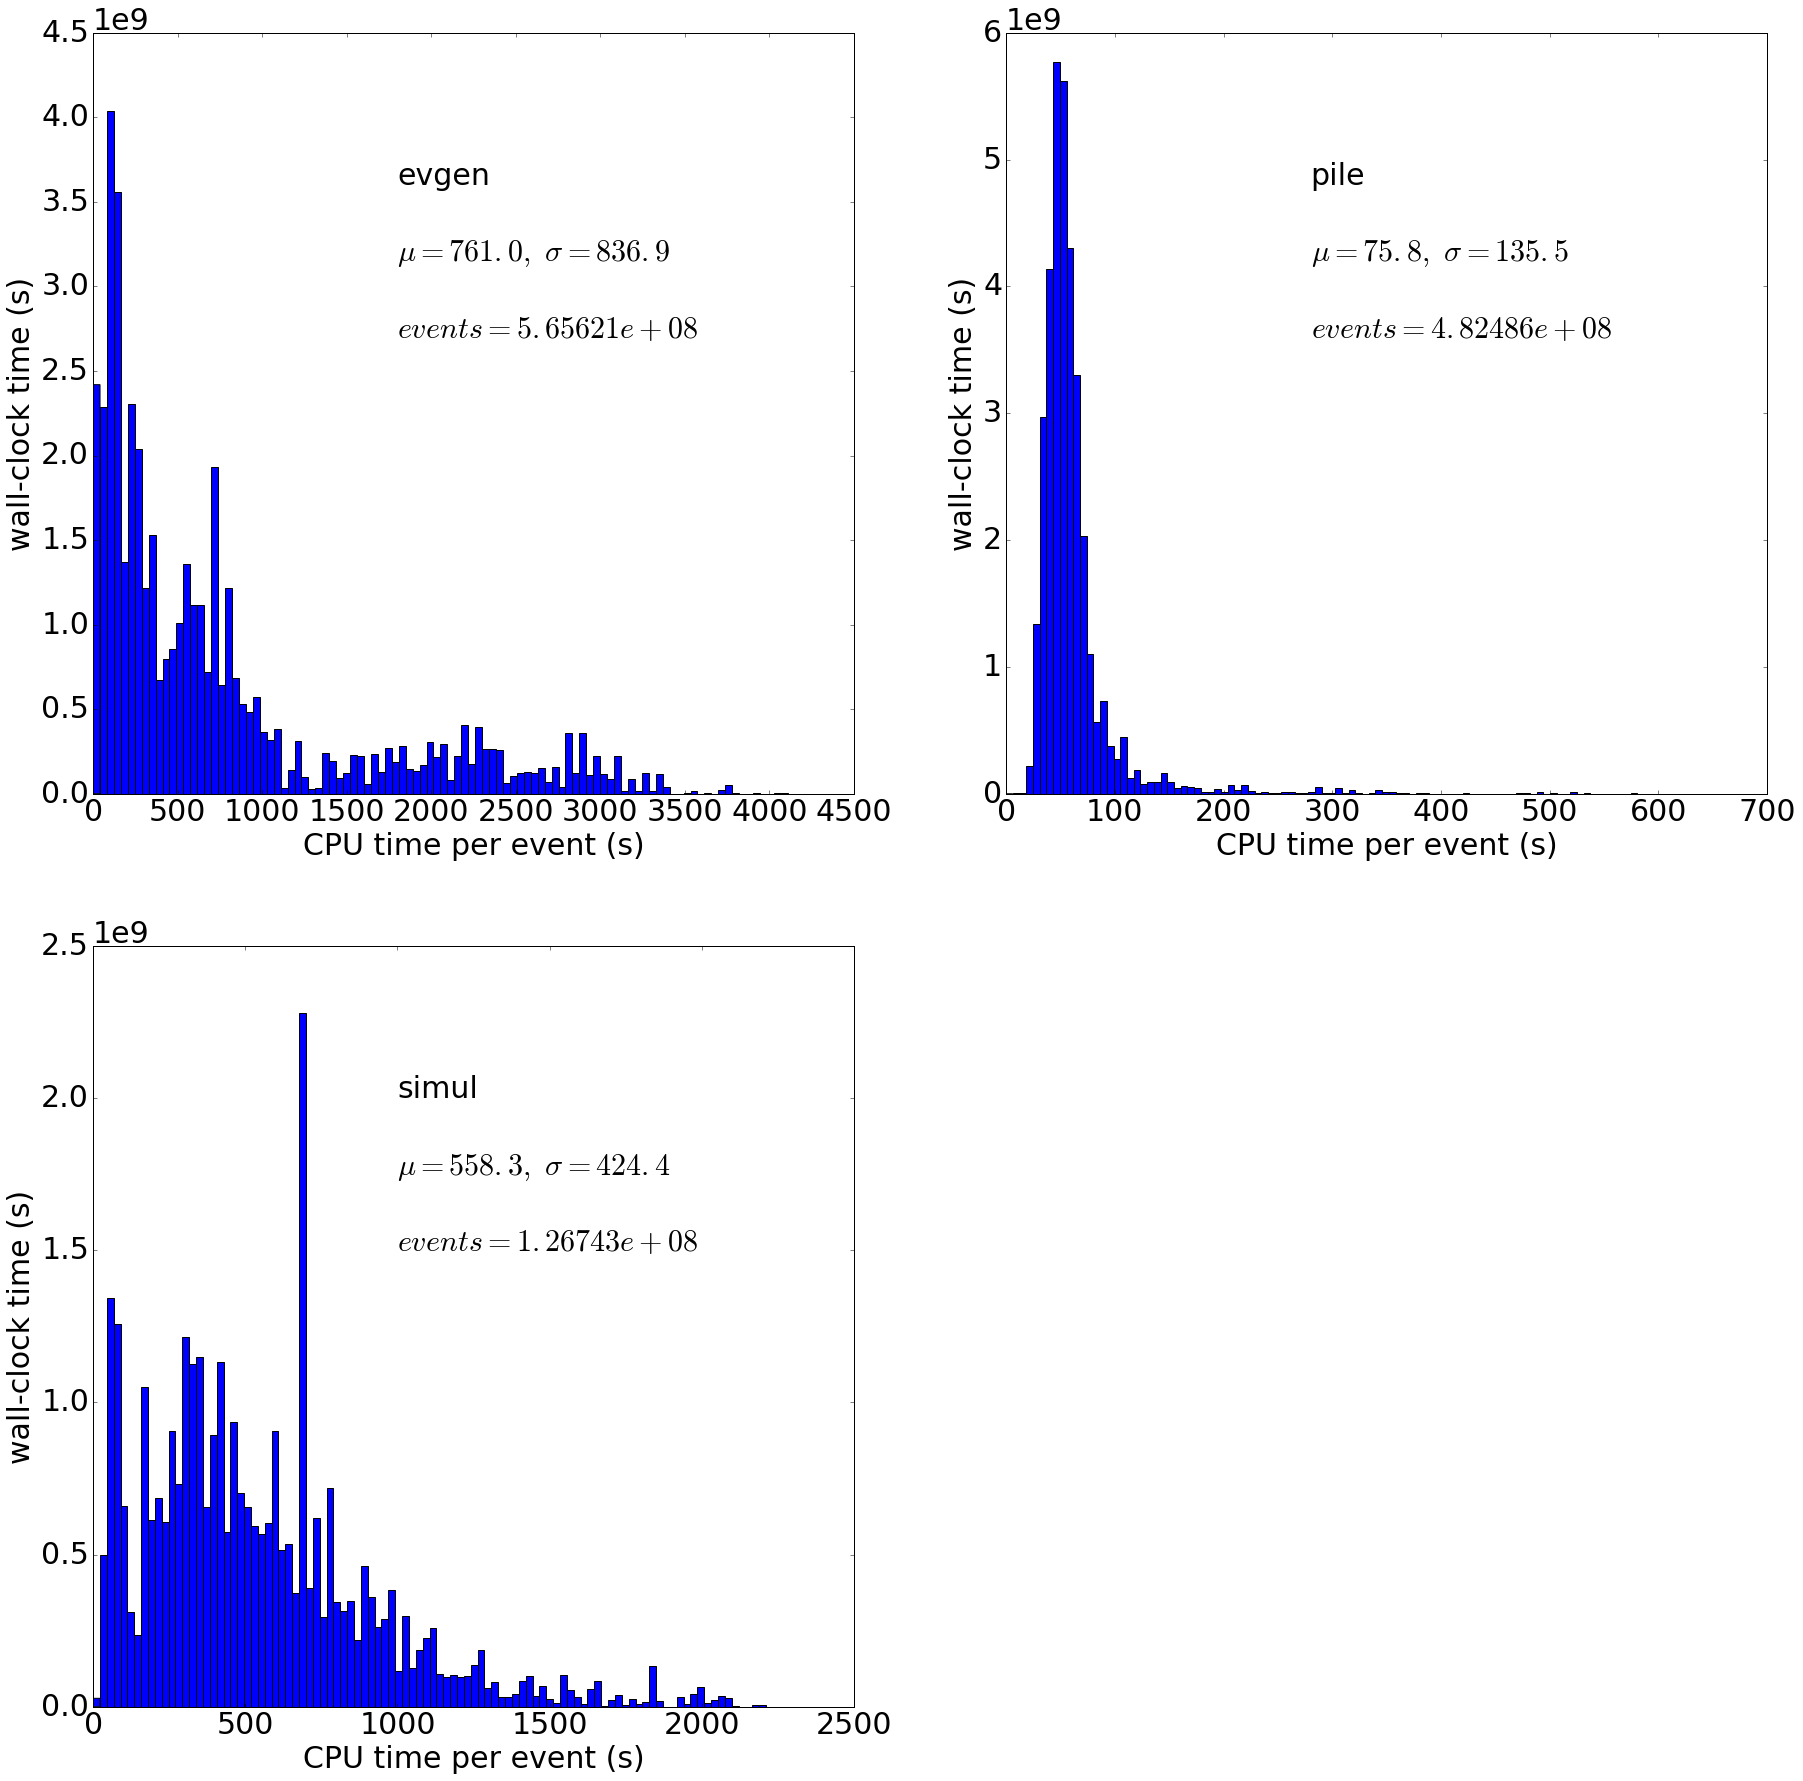

In [19]:
fig = plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 4., 6000.)]
    sp = plt.subplot(2, 2, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stat = r'$\mu=%.1f,\ \sigma=%.1f$' % (mean, std)
    stat2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stat)
        plt.text(t_x(.4), t_y(.6), stat2)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

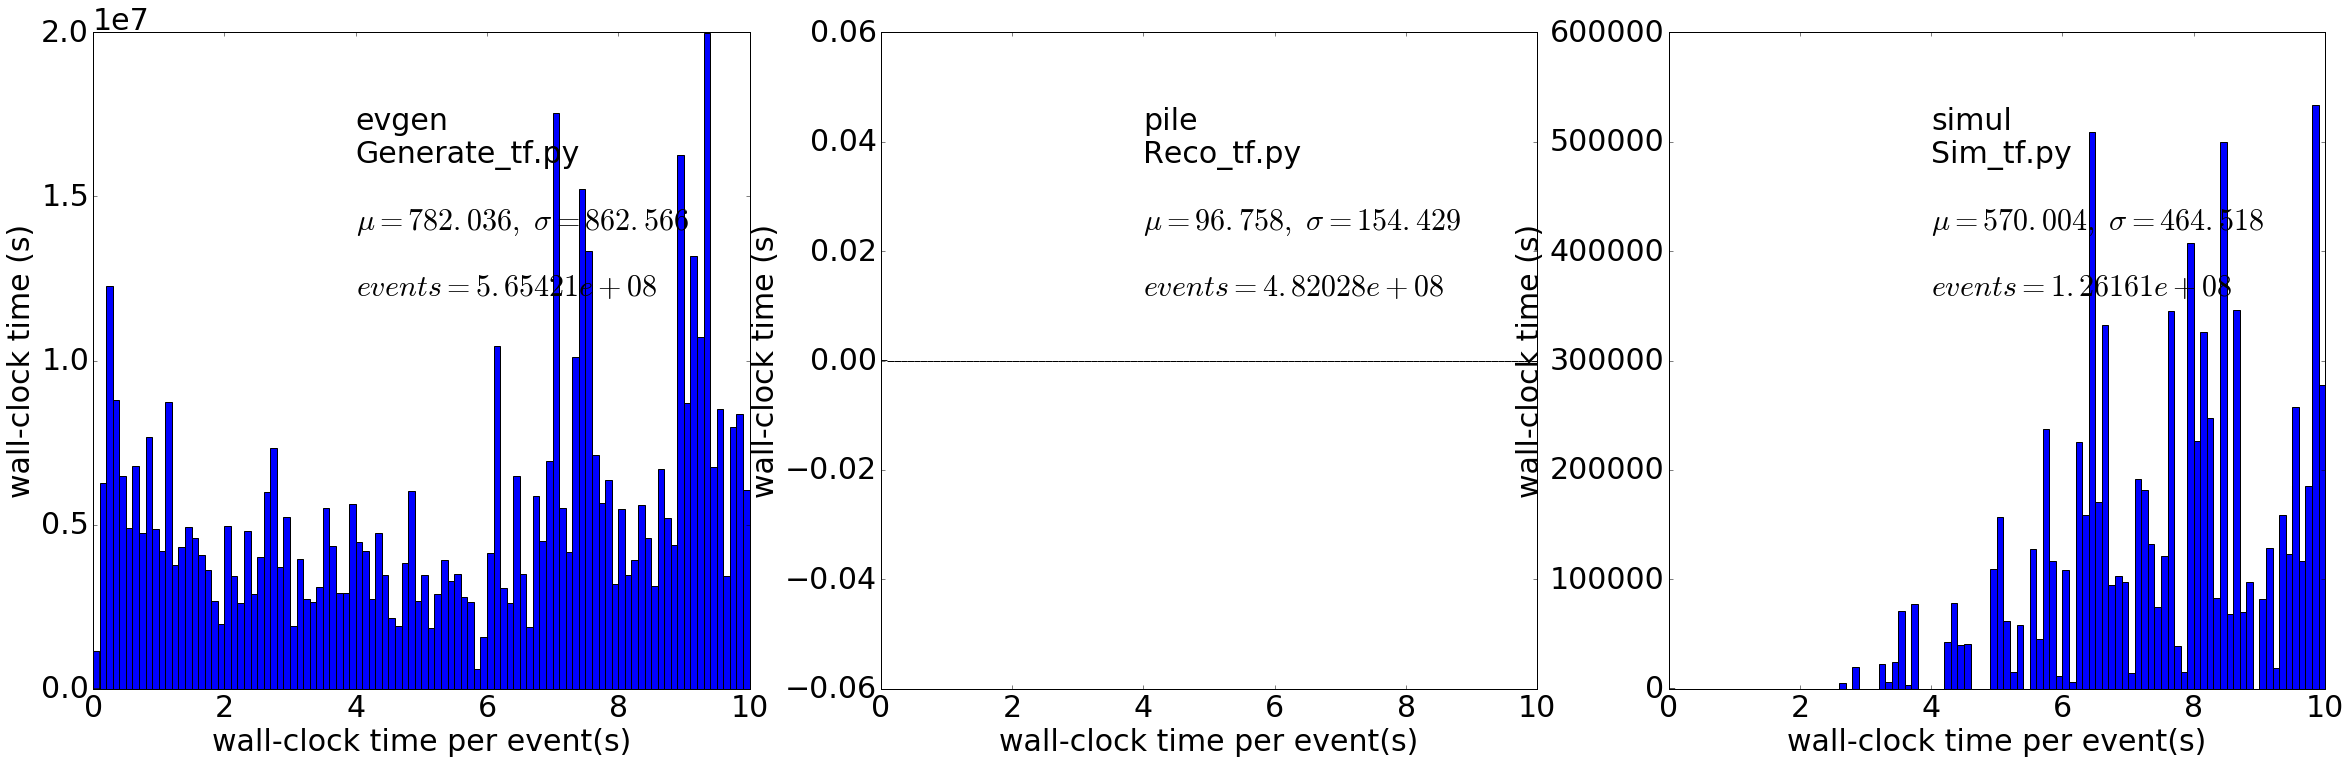

In [20]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
#    range = [0., min(mean + std * 5., 8000.)]
    range = [0., 10.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stat2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stat)
        plt.text(t_x(.4), t_y(.6), stat2)
    i += 1

Again, let's redo without aggregating on the transformation.

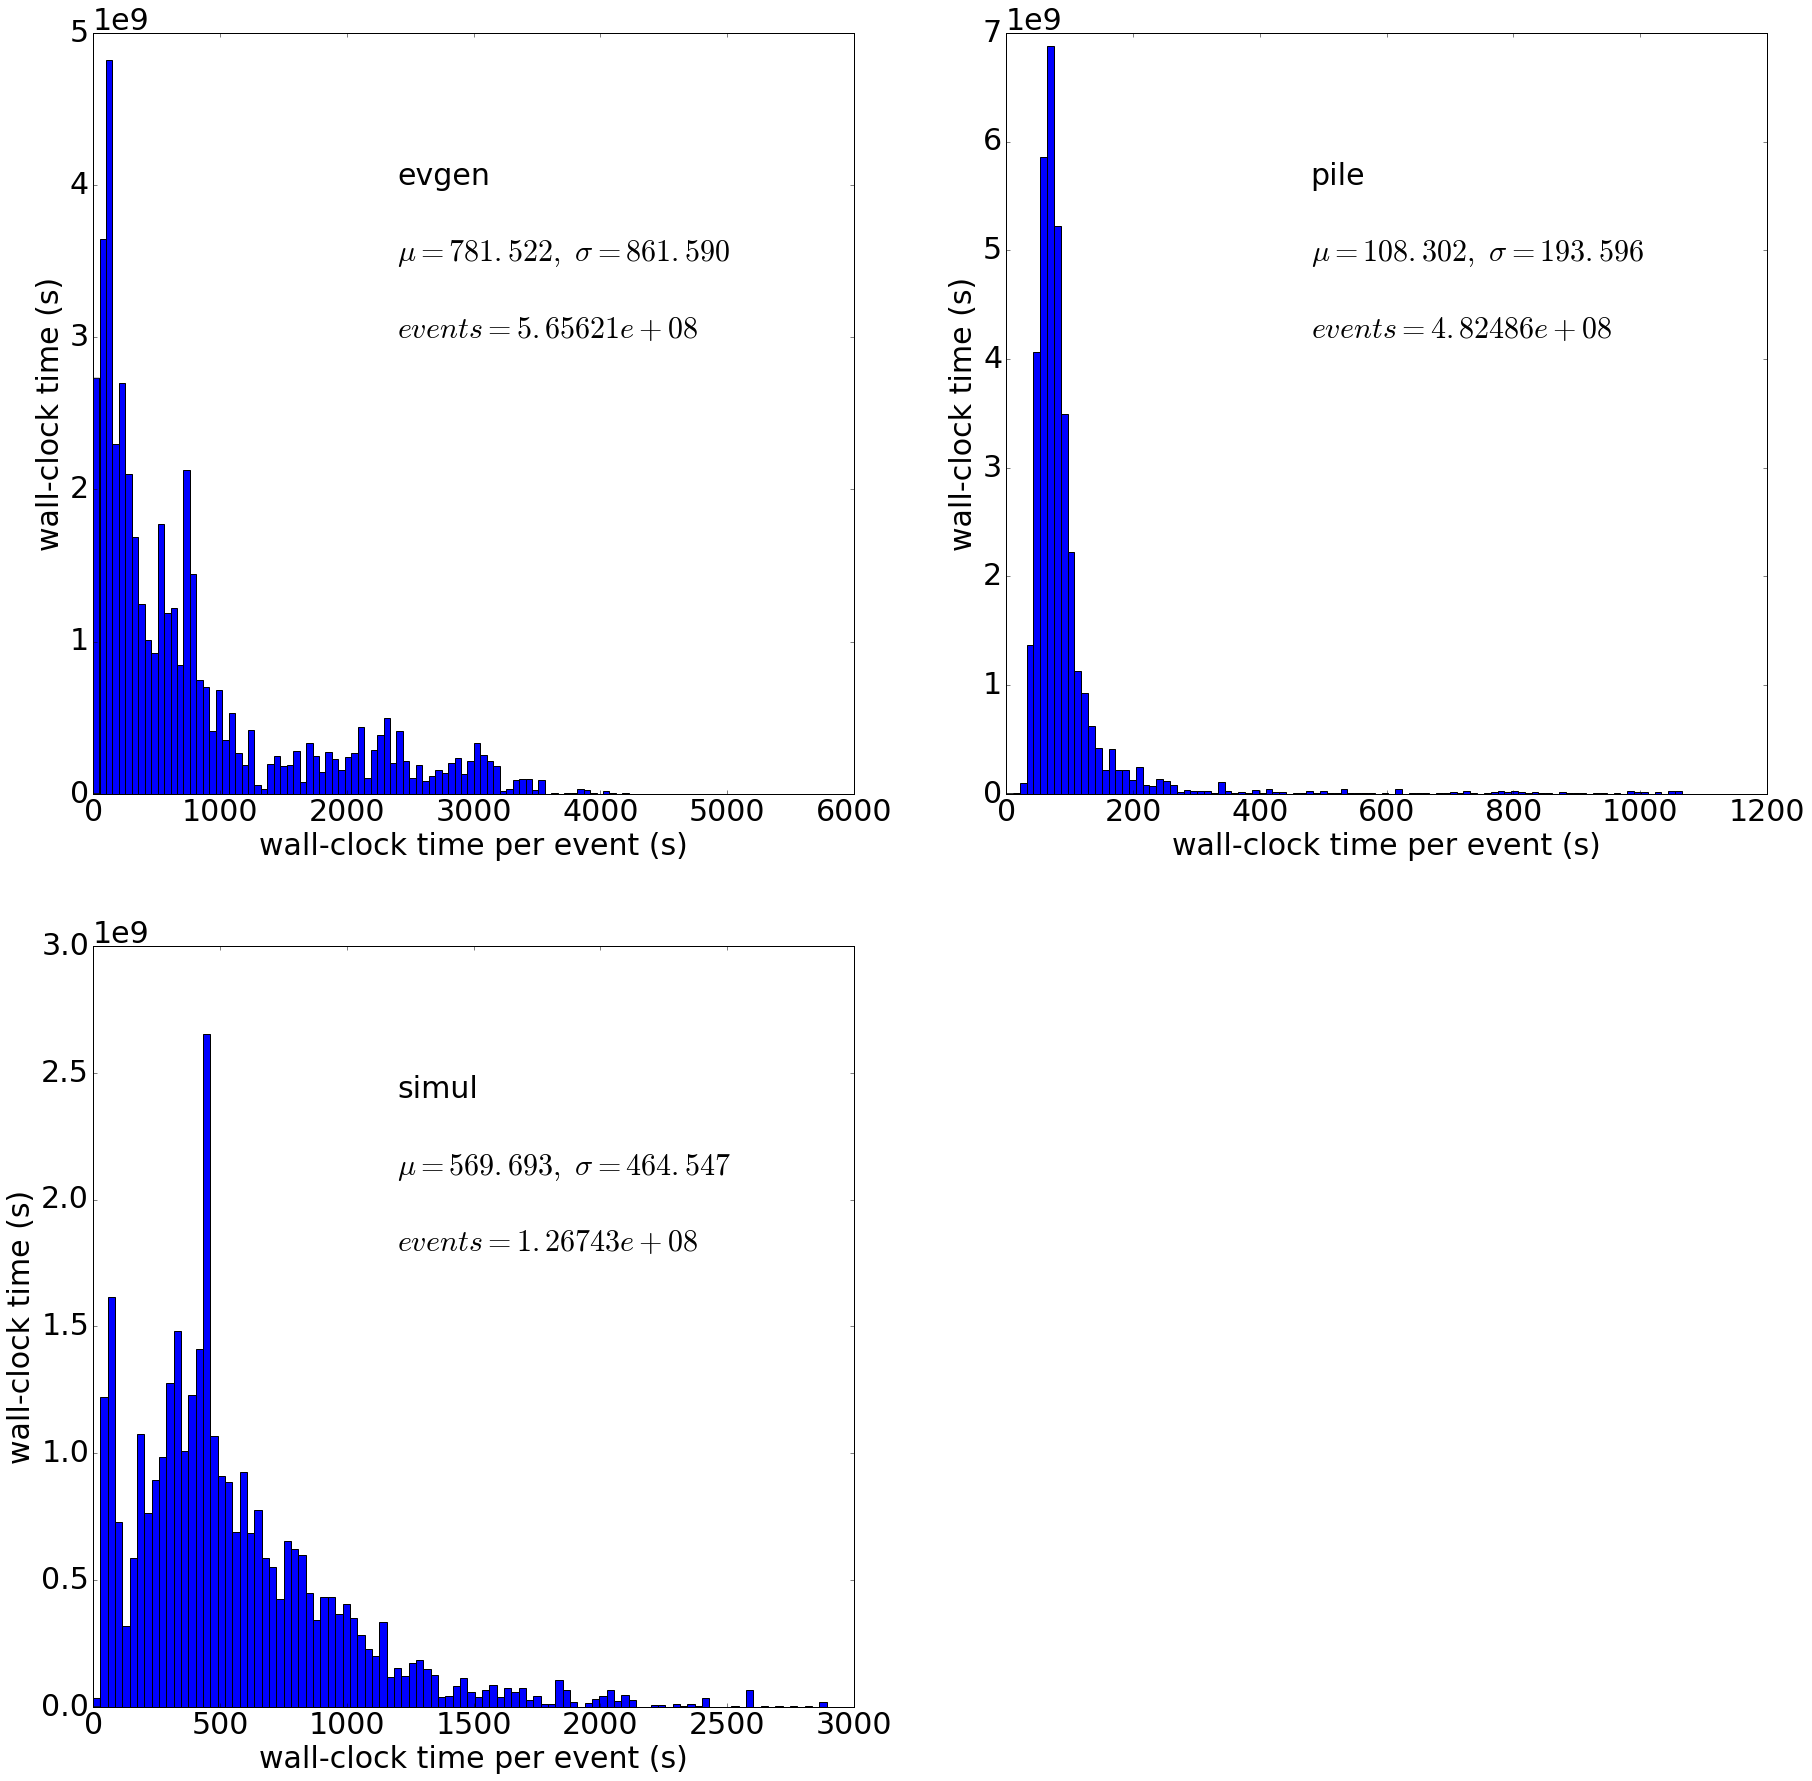

In [21]:
fig = plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 5., 8000.)]
    sp = plt.subplot(2, 2, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stat2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stat)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stat2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stat)
        plt.text(t_x(.4), t_y(.6), stat2)
    i += 1

## Plot distribution of averages of CPU efficiency per event for tasks grouped by processingtype and transformation

Total wall-clock: 1.16521e+11 s
Total wall-clock of evgen: 4.48477e+10 s
Total wall-clock of evgen with low efficiency: 3.26419e+08 s


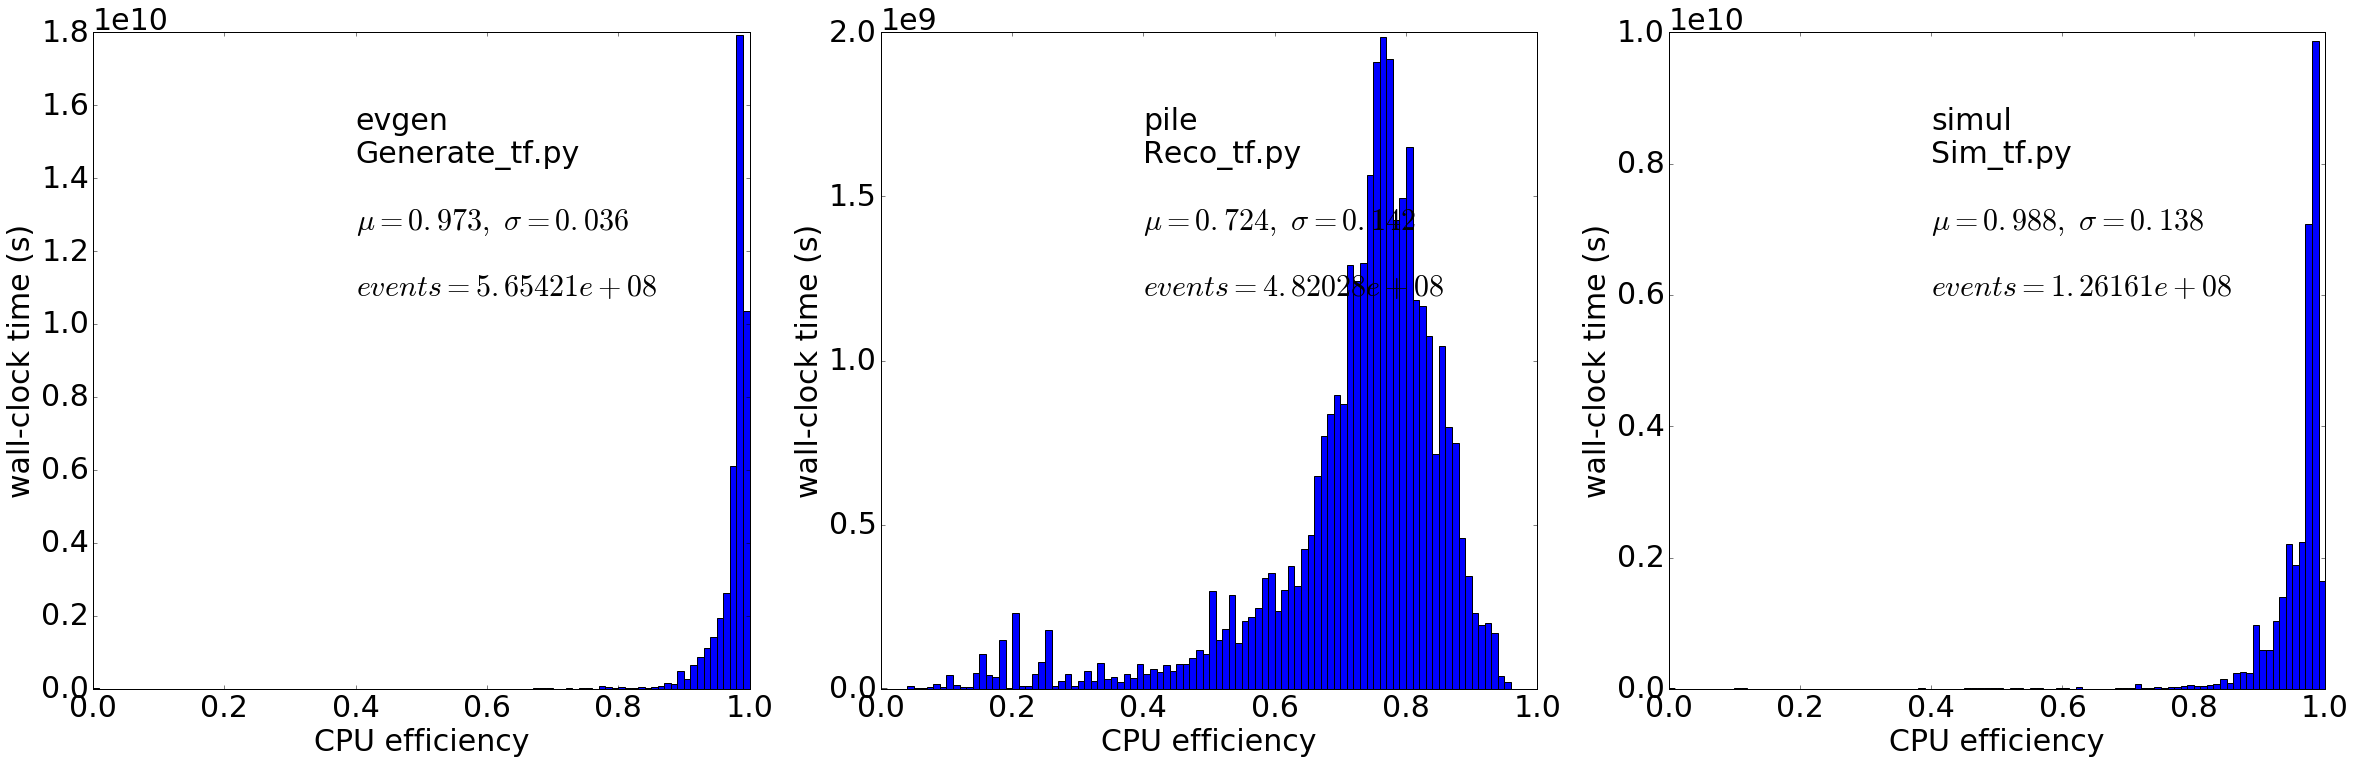

In [22]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
wc_tot = df['wc'].sum()
print 'Total wall-clock: %g s' % wc_tot
print 'Total wall-clock of evgen: %g s' % df[df.processingtype == 'evgen']['wc'].sum()
print 'Total wall-clock of evgen with low efficiency: %g s' % df[(df.processingtype == 'evgen') & (df['eff'] <= .8)]['wc'].sum()

i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if i > 9: break
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 1.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=False)   # integral is total no. of events
    plt.xlabel('CPU efficiency')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p+'\n'+t)
    stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stat)
    stat = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stat)
    i += 1

Again, without transformation.

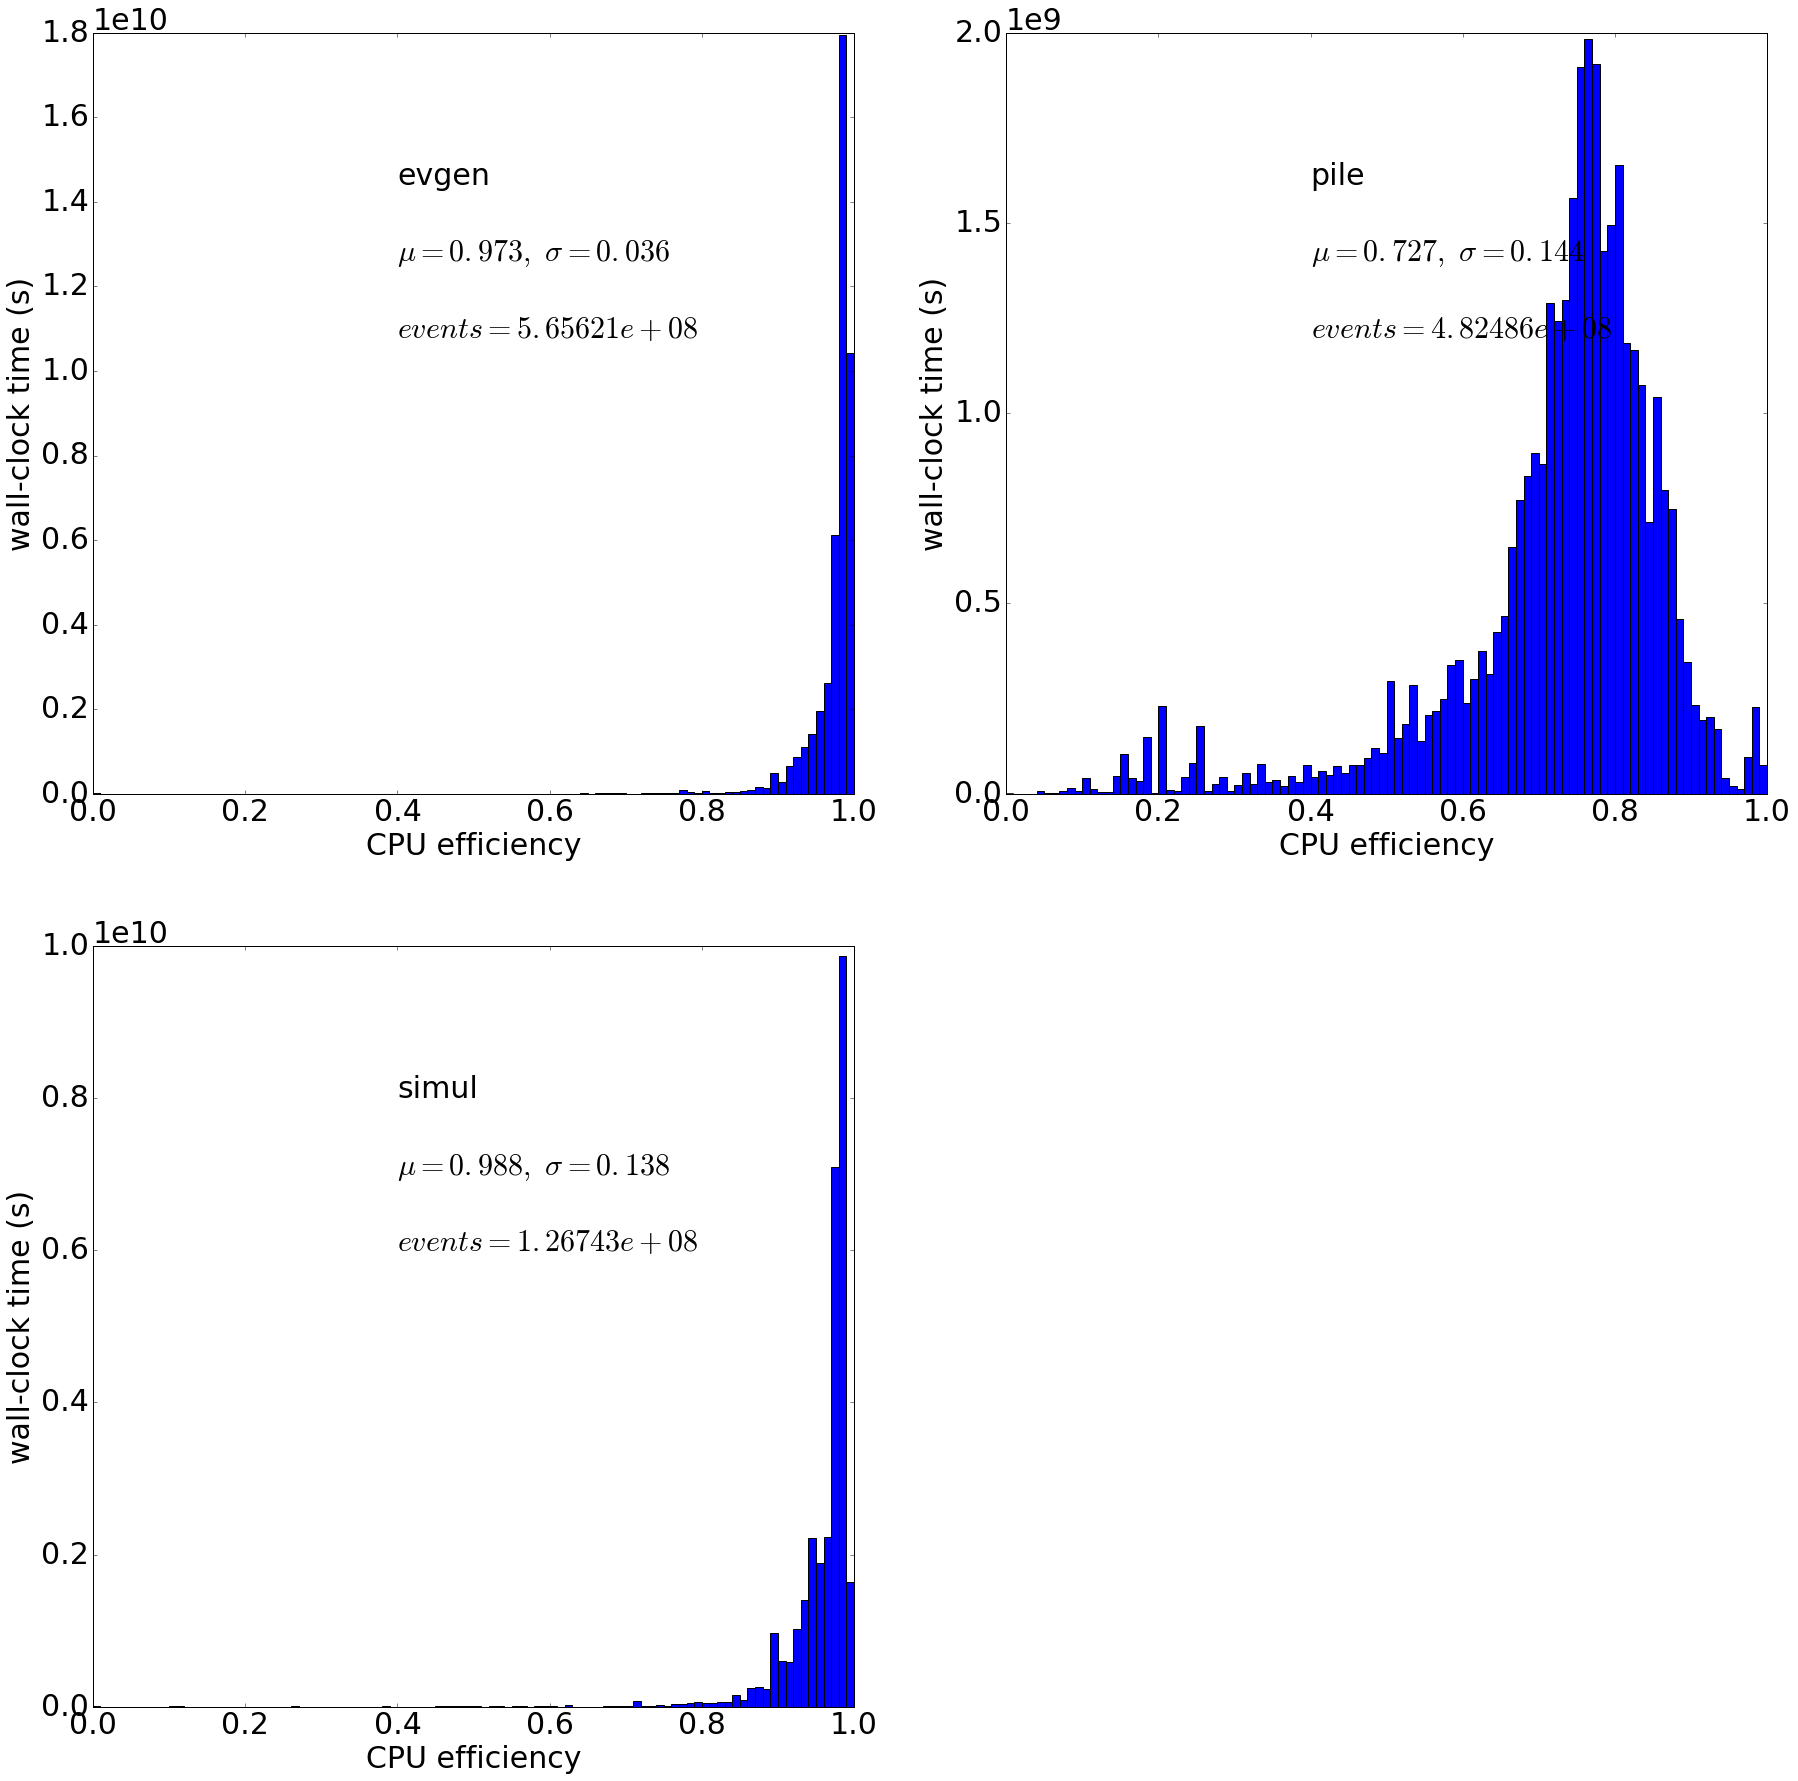

In [23]:
fig = plt.figure(figsize=(30, 30))
plt.rcParams.update({'font.size': 30})
var = 'eff'
wc_tot = df['wc'].sum()

i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if i > 9: break
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 1.]
    sp = plt.subplot(2, 2, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=False)   # integral is total no. of events
    plt.xlabel('CPU efficiency')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p)
    stat = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stat)
    stat = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stat)
    i += 1

## Find tasks with a given efficiency

In [24]:
ptype = 'reprocessing'
trans = 'Reco_tf.py'
eff_range = [0., 0.1]

tasks = list()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    mean = np.average(g['eff'], weights=g['jevts'])   # average time weighted with no. of events
    if eff_range[0] <= mean <= eff_range[1]:
        tasks.append(j)

In [25]:
print tasks[:10]
#df[df['jeditaskid'] == 4608021]
df[df['jeditaskid'] == tasks[0]]

[10210737, 10210745, 10210755, 10210758, 10210761, 10210764, 10210773, 10210776, 10210779, 10210782]


,jeditaskid,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,actualcores,cores,jevts,eff
52889,10210737,reprocessing,Reco_tf.py,Atlas-20.7.8,BNL_PROD_MCORE,s+Intel(R) Xeon(R) CPU E5-2660 v3 @ 2.60GHz 25...,1,1103.75,0.0,11806.0,0.0,4415.0,47224.0,8.0,8.0,4.0,0.093491


## Distribution of time/event for jobs inside a task

In [26]:
ptype = 'evgen'
trans = 'Generate_tf.py'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    tot_evts[j] = g['jevts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:1]
random_task = np.random.choice(a, 1)
print random_task

[10227729]


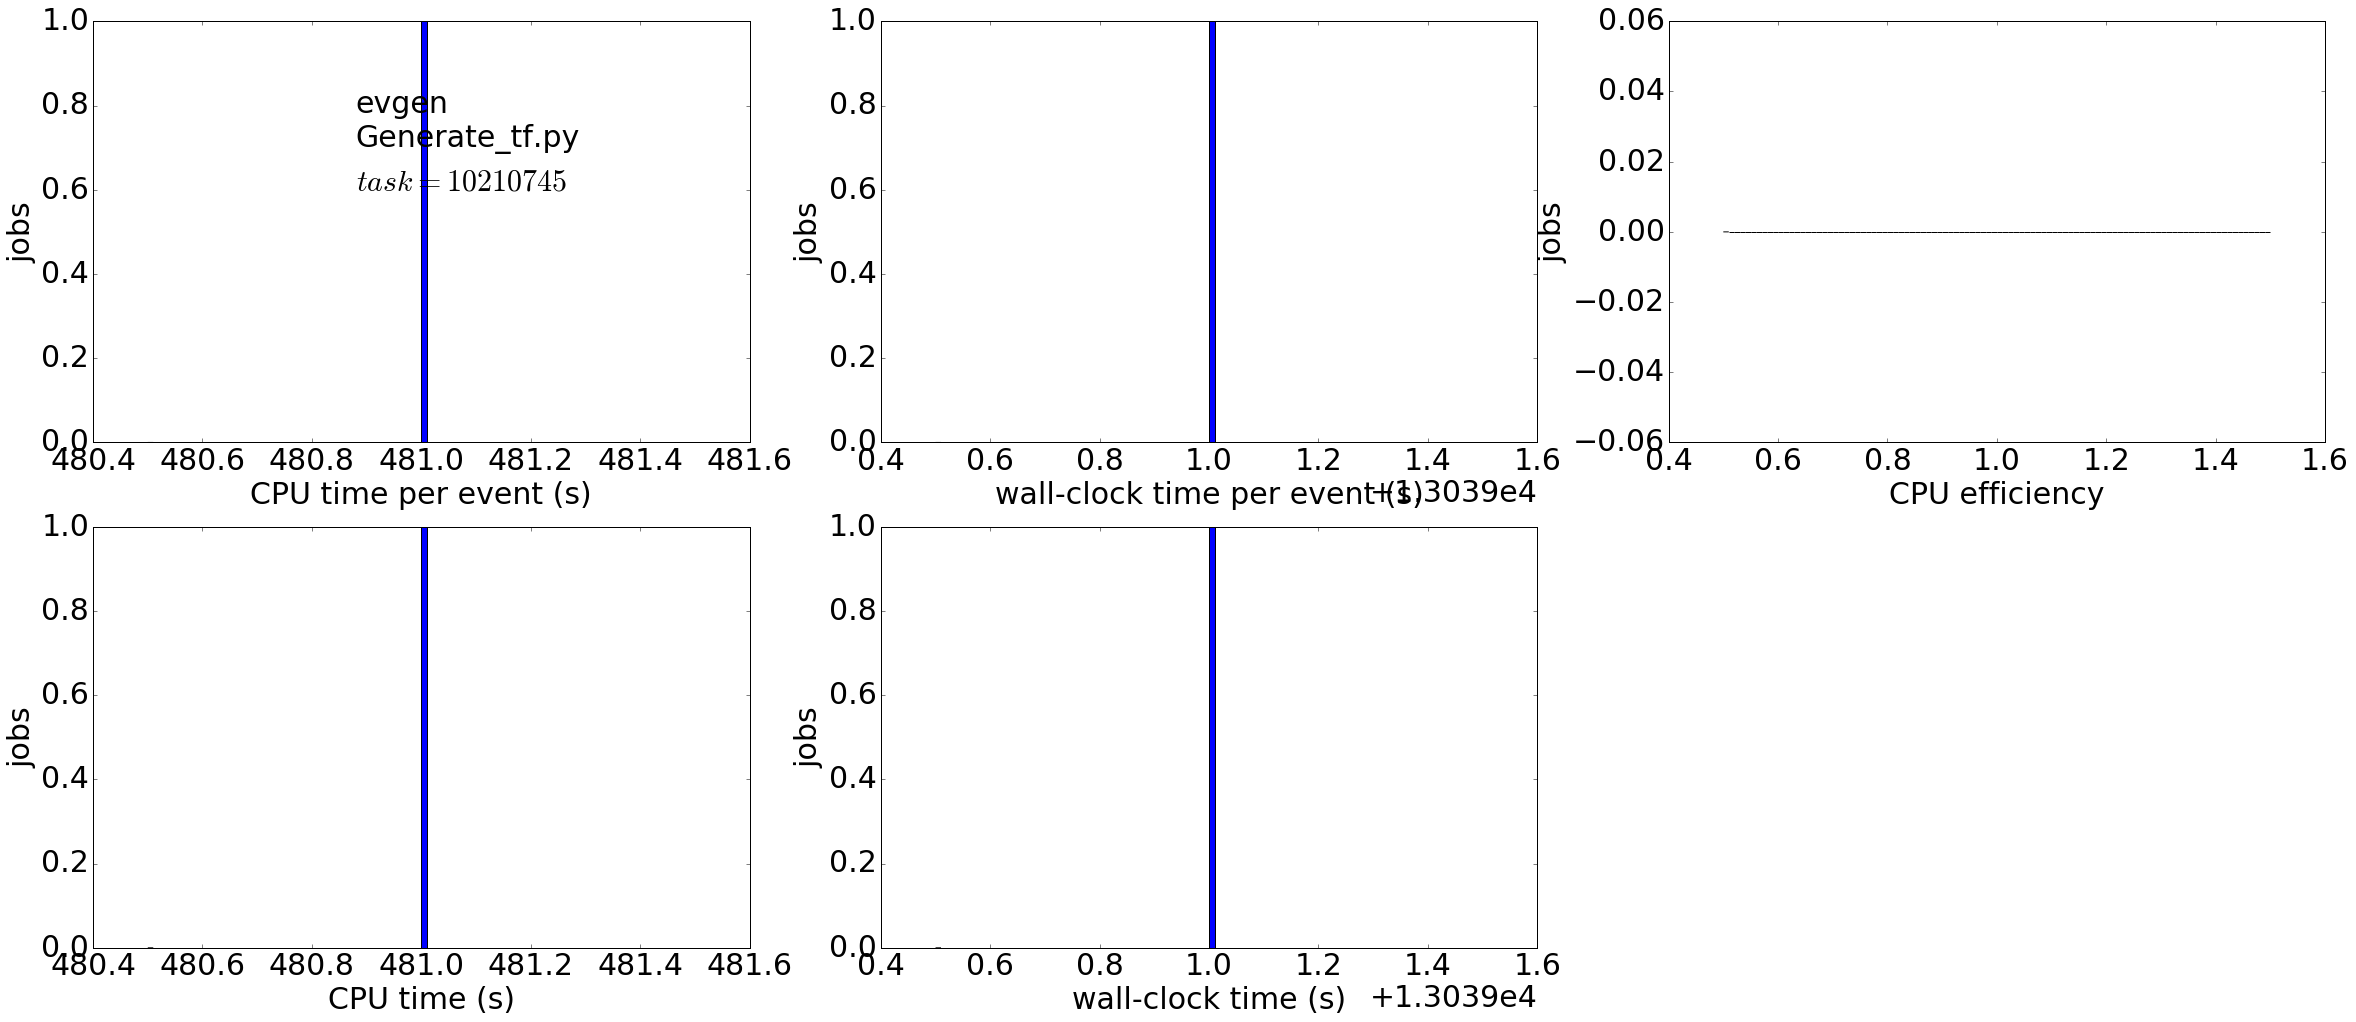

In [27]:
#random_task = [5309444]
random_task = [ tasks[1] ]
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 10000,
        "_source": ["cpuconsumptiontime", "wall_time", "actualcorecount", "corecount", "nevents", "pandaid"],
        "query": {
            "constant_score": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "jeditaskid": str(t)}},
                            { "range": {"nevents": {"gte": 1}}},
                            { "range": {"wall_time": {"gte": 60}}},
                            { "match": {"jobstatus": "finished"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    cores = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        if vars['actualcorecount']:
            core = vars['actualcorecount']
        else:
            core = vars['corecount']
        cpuevt = vars['cpuconsumptiontime'] / vars['nevents']
        wcevt = vars['wall_time'] * core / vars['nevents']
        eff = vars['cpuconsumptiontime'] / vars['wall_time'] / core
        cpu = vars['cpuconsumptiontime']
        wc = vars['wall_time'] * core
        pandaid = vars['pandaid']
        if eff > 1.:
            print eff, cpu, wc, core, pandaid
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        cores.append(core)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=None)
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype+'\n'+trans)
    stat = r'$task=%d$' % (t)
    plt.text(t_x(.4), t_y(.6), stat)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=None)
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=[0.5, 1.5])
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5

## Examine a single task

See the distribution of the CPU time per event across different sites for a single task.

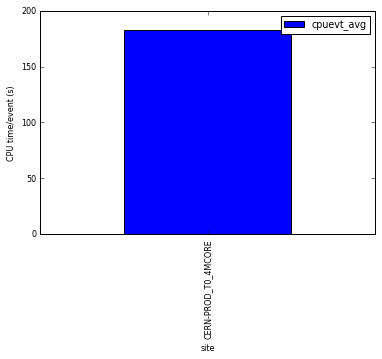

In [28]:
#taskid = 8762011
taskid = tasks[2]
dfx = df[df['jeditaskid'] == taskid]
df2 = dfx.groupby('site').aggregate({'cpuevt_avg': np.mean})
plt.rcParams.update({'font.size': 8})
plt.figure()
df2.sort_values('cpuevt_avg').plot.bar()
plt.ylabel('CPU time/event (s)')

## Distribution of average CPU time per event across different sites for a given task

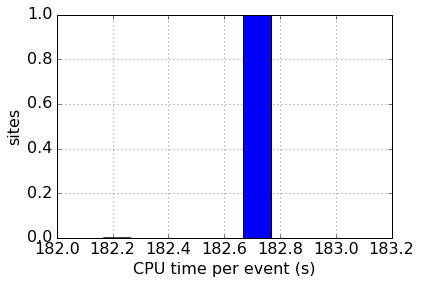

In [29]:
plt.rcParams.update({'font.size': 16})
df2['cpuevt_avg'].hist(bins=10)
plt.xlabel('CPU time per event (s)')
plt.ylabel('sites')

## Analyse all tasks

Study the spread in the CPU time per event on different sites.

In [30]:
ptype = 'evgen'
k = list()
ns = list()
grouped = df.groupby(['jeditaskid', 'site'], as_index=False)
g = grouped['cpuevt_avg'].agg(np.mean)
tasks = g['jeditaskid'].unique()
for t in tasks:
    g2 = g[g.jeditaskid == t]
    n = len(g2)
    ns.append(n)
    if len(g2) < 3: continue
    avg = g2['cpuevt_avg'].mean()   # wrong: mean not weighted
    std = g2['cpuevt_avg'].std()   # wrong: mean not weighted
    if np.isnan(std): continue
    try:
        ratio = std / avg
        k.append(ratio)
    except:
        continue

### Distribution of number of sites used by a task

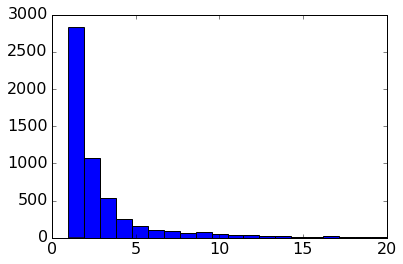

In [31]:
fig = plt.hist(ns, bins=20, range=(1, 20))

### Distribution of the normalised spread of the CPU time per event across different sites

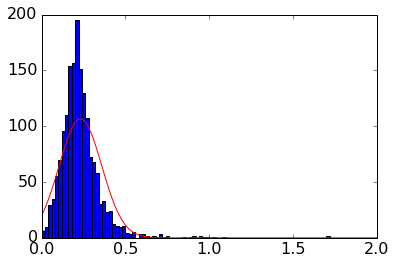

In [32]:
bins = 100
range = (0, 2)
hist_range = (0, 2)
n = len(k)
mu = np.mean(k)
sigma = np.std(k)
fig = plt.hist(k, bins=bins, range=range)
binsize = (range[1] - range[0]) / bins
plt.plot(fig[1], n * binsize/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (fig[1] - mu)**2 / (2 * sigma**2)), color='r')

## Distribution of number of CPU types per site

builtin_function_or_method

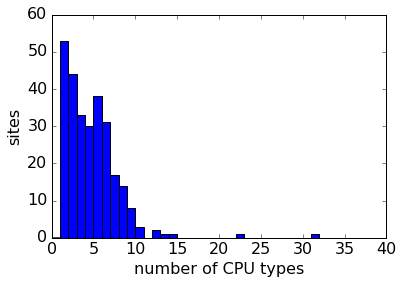

In [33]:
grouped = df.groupby(['site'], as_index=False)
a = grouped.agg({'cputype': 'nunique'})
fig = plt.hist(a['cputype'], bins=40, range=[0., 40.])
plt.xlabel('number of CPU types')
plt.ylabel('sites')
range = range_func  # restore range() function
#print range(10)
type(range_func)

## Ranking of sites by wall-clock

In [ ]:
grouped = df.groupby(['site'], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
a[a.wc > bigtotal_wc * 0.001].site.tolist()

## Find task data

In [35]:
indices = es.cat.indices(index="tasks*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [unicode.strip(x) for x in indices if x != '']
ind = ','.join(indices)
print ind

tasks_archive_2014,tasks_archive_2015,tasks_archive_2016,tasks_archive_2016-04,tasks_archive_2016-05,tasks_archive_2016-06,tasks_archive_2016-07,tasks_archive_2016-08,tasks_archive_2016-09,tasks_archive_2016-10,tasks_archive_2016-11,tasks_archive_2016-12


### A new helpers.scan()

'**scan**' search type has been deprecated since ES-2.1.0 [1] and thus `helpers.scan()` does not work in ES >= 2.1.  The following is a new `scan()` method copied from elasticsearch-py github.  The doc string is removed so see the link to see the doc.
 
[1] https://www.elastic.co/guide/en/elasticsearch/reference/2.3/search-request-search-type.html#scan

> Deprecated in 2.1.0.
>
> `scan` does not provide any benefits over a regular `scroll` request sorted by `_doc`.

In [36]:
# Copied from elasticsearch-py
#  https://github.com/elastic/elasticsearch-py/blob/master/elasticsearch/helpers/__init__.py
#
def scan(client, query=None, scroll='5m', raise_on_error=True,
         preserve_order=False, size=1000, request_timeout=None, clear_scroll=True, **kwargs):
    """
    Simple abstraction on top of the elasticsearch.Elasticsearch.scroll api
    """
    if not preserve_order:
        query = query.copy() if query else {}
        query["sort"] = "_doc"
    # initial search
    resp = client.search(body=query, scroll=scroll, size=size,
                         request_timeout=request_timeout, **kwargs)

    scroll_id = resp.get('_scroll_id')
    if scroll_id is None:
        return

    try:
        first_run = True
        while True:
            # if we didn't set search_type to scan initial search contains data
            if first_run:
                first_run = False
            else:
                resp = client.scroll(scroll_id, scroll=scroll, request_timeout=request_timeout)

            for hit in resp['hits']['hits']:
                yield hit

            # check if we have any errrors
            if resp["_shards"]["failed"]:
                logger.warning(
                    'Scroll request has failed on %d shards out of %d.',
                    resp['_shards']['failed'], resp['_shards']['total']
                )
                if raise_on_error:
                    raise ScanError(
                        scroll_id,
                        'Scroll request has failed on %d shards out of %d.' %
                            (resp['_shards']['failed'], resp['_shards']['total'])
                    )

            scroll_id = resp.get('_scroll_id')
            # end of scroll
            if scroll_id is None or not resp['hits']['hits']:
                break
    finally:
        if scroll_id and clear_scroll:
            client.clear_scroll(body={'scroll_id': [scroll_id]}, ignore=(404, ))


In [37]:
fields = ["campaign", "corecount", "cpuefficiency", "creationdate", "jeditaskid", "processingtype", "prodsourcelabel", "site", "starttime",  "status", "taskname"]
s = {
    "_source": fields,
    "query": {
        "constant_score": {
            "filter": {
                #"match": { "tasktype": "prod"}
                "term": { "tasktype": "prod"}
            }
        }
    }
}
#res = es.search(index=ind, body=s, request_timeout=300)
output_file = 'tasksdata.csv'
with open(output_file, 'w') as f:
    writer = csv.DictWriter(f, fieldnames=fields, lineterminator='\n')
    if elasticsearch.__version__[0] >= 5:
        res = helpers.scan(es, query=s, index=ind)
    else:
        res = scan(es, query=s, index=ind)
    for r in res:
        attrs = r['_source']
        writer.writerow(attrs)

In [38]:
df_t = pd.read_csv(output_file, names=fields)
jmap = df_t[['jeditaskid', 'taskname', 'campaign']]
df2 = pd.merge(df, jmap, on='jeditaskid')

In [39]:
df2[df2.eff > 1.9][:5]

,jeditaskid,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,actualcores,cores,jevts,eff,taskname,campaign


## Split data file into N random samples

In [42]:
range = range_func  # restore reange() func
#input = 'task_cpu.csv'
input = 'task_cpu_90d_xxx.csv'
no_outputs = 2
g = list()
output_pattern = 'task_cpu_sub_%s.csv'
p = re.compile('\d+')
jtask_old = ''
for i in range(no_outputs):
    gname = output_pattern % (str(i))
    g.append(open(gname, 'w'))
    
with open(input) as f:
    data = f.readlines()
    data.sort()
    for line in data:
        jtask = p.match(line).group(0)
        if jtask != jtask_old:
            jtask_old = jtask
            i = random.randint(0, no_outputs-1)
        g[i].write(line)

for i in range(no_outputs):
    g[i].close()